Training PINN (0–200 ms) …
  Adam epoch     0  loss=3.628e+04
  Adam epoch  3000  loss=3.261e-01
  Adam epoch  6000  loss=3.261e-01
  Adam epoch  9000  loss=3.253e-01
  Adam epoch 12000  loss=4.333e-02
  LBFGS final loss = 4.664e-04

Euler reference values:
 t=  0.0  v=-60.0000  w=  0.0000
 t=250.0  v=-54.4819  w=  6.2834
 t=500.0  v=-50.6154  w= 59.0910
 t=750.0  v=-49.5530  w=-12.4763
 t=1000.0  v=-53.6973  w=  1.5649

RK4 values:
 t=  0.0  v=-60.0000  w=  0.0000
 t=250.0  v=-54.4924  w=  6.3043
 t=500.0  v=-53.0235  w= 46.7586
 t=750.0  v=-48.5671  w=-14.2254
 t=1000.0  v=-52.8363  w= -2.5030


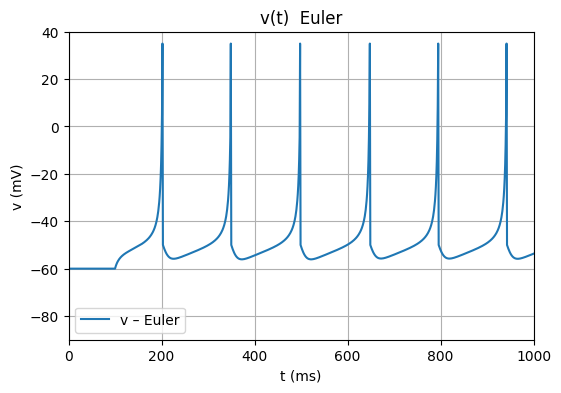

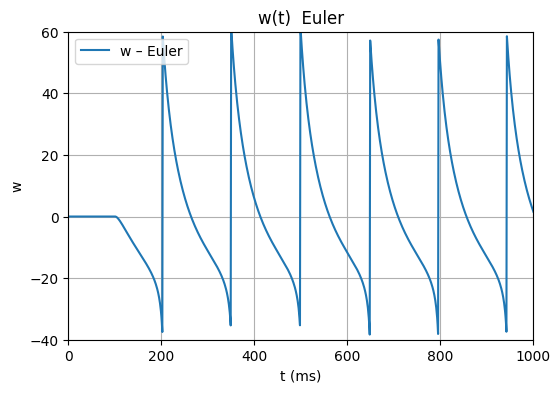

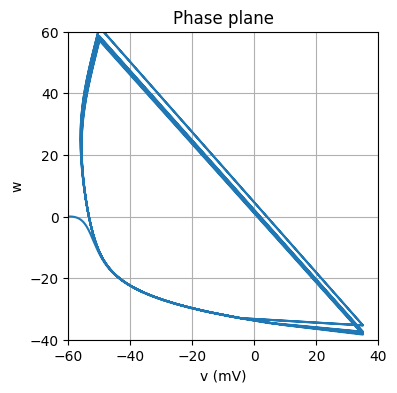

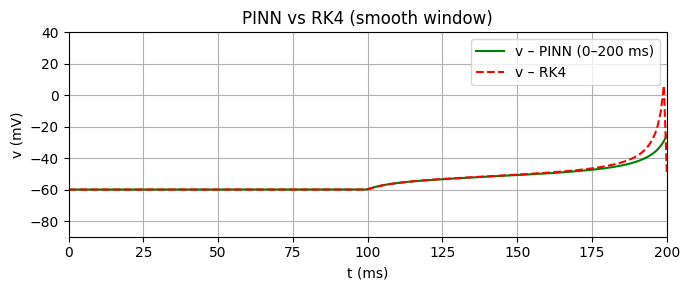

In [11]:
# ============================================================
# Dynamic-Neuron Model (Schiesser, ch.4) – with correct PINN
# ============================================================

import numpy as np, torch, torch.nn as nn, matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------------
# 1. PARAMETERS (Regular-Spiking pyramidal neuron) – book values
# ------------------------------------------------------------------
C   = 100.0
vr  = -60.0
vt  = -40.0
k   =   0.7
a   = 0.03
b   = -2.0
c   = -50.0
d   = 100.0
v_peak = 35.0

# ------------------------------------------------------------------
# 2. INPUT CURRENT  In(t) (step at 100 ms)
# ------------------------------------------------------------------
def In_scalar(t):
    return 70.0 if t >= 100.0 else 0.0

def In_tensor(t):
    return 70.0 * (t >= 100).float()

# ------------------------------------------------------------------
# 3. EULER SOLVER (for Schiesser's plots)
# ------------------------------------------------------------------
def euler(C, h, t0, t_end, v0, w0):
    n  = int((t_end - t0) / h)
    ts = np.linspace(t0, t_end, n + 1)
    v  = np.zeros_like(ts); w = np.zeros_like(ts)
    v[0], w[0] = v0, w0
    for i in range(n):
        dv = (1/C)*(k*(v[i]-vr)*(v[i]-vt) - w[i] + In_scalar(ts[i]))
        dw = a*(b*(v[i]-vr) - w[i])
        v[i+1] = v[i] + h*dv
        w[i+1] = w[i] + h*dw
        if v[i+1] >= v_peak:
            v[i]   = v_peak
            v[i+1] = c
            w[i+1] = w[i+1] + d
    return ts, v, w

# ------------------------------------------------------------------
# 4. RK4 SOLVER
# ------------------------------------------------------------------
def rk4(t0, t_end, h, y0):
    def f(t, y):
        v, w = y
        dv = (1/C)*(k*(v-vr)*(v-vt) - w + In_scalar(t))
        dw = a*(b*(v-vr) - w)
        return np.array([dv, dw])

    n  = int((t_end - t0) / h)
    ts = np.linspace(t0, t_end, n + 1)
    ys = np.zeros((n + 1, 2)); ys[0] = y0
    for i in range(n):
        t, y = ts[i], ys[i]
        k1 = f(t, y)
        k2 = f(t+h/2, y + h/2*k1)
        k3 = f(t+h/2, y + h/2*k2)
        k4 = f(t+h,   y + h*k3)
        y_next = y + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        if y_next[0] >= v_peak:
            y_next[0] = c
            y_next[1] += d
        ys[i+1] = y_next
    return ts, ys[:,0], ys[:,1]

# ------------------------------------------------------------------
# 5. PINN – with correct loss graph (Option A)
# ------------------------------------------------------------------
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 2))
    def forward(self, t): return self.net(t)

# collocation points: oversample 100–200 ms
t_full = np.hstack([
    np.linspace(0, 100, 400, endpoint=False),
    np.linspace(100, 200, 800)
])
t_full = torch.tensor(t_full, dtype=torch.float32).view(-1,1).to(device)
t_scaled = t_full / 200.0  # scale to [0, 1]

model = PINN().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)

# Correct loss function (fresh t graph every time)
def pinn_loss(t_const):
    t = t_const.detach().clone().requires_grad_(True)
    t_phys = t * 200.0
    pred = model(t)
    v, w = pred[:, 0:1], pred[:, 1:2]

    dv = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True)[0] / 200.0
    dw = torch.autograd.grad(w, t, torch.ones_like(w), create_graph=True)[0] / 200.0

    f1 = dv - (1/C)*(k*(v-vr)*(v-vt) - w + In_tensor(t_phys))
    f2 = dw - a*(b*(v-vr) - w)

    ic = 10*((v[0] - vr)**2 + (w[0])**2)
    return torch.mean(f1**2) + torch.mean(f2**2) + ic

# Train with Adam
print("Training PINN (0–200 ms) …")
for epoch in range(15000):
    opt.zero_grad()
    loss = pinn_loss(t_scaled)
    loss.backward()
    opt.step()
    if epoch % 3000 == 0:
        print(f"  Adam epoch {epoch:5d}  loss={loss.item():.3e}")

# Final optimization with LBFGS
lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=500, tolerance_grad=1e-7)

def closure():
    lbfgs.zero_grad()
    l = pinn_loss(t_scaled)
    l.backward()
    return l

lbfgs.step(closure)
print(f"  LBFGS final loss = {pinn_loss(t_scaled).item():.3e}")

# Inference for plotting
with torch.no_grad():
    t_plot = torch.linspace(0, 200, 400).view(-1,1).to(device)
    v_pred, w_pred = model(t_plot/200.0).cpu().numpy().T
    t_plot = t_plot.cpu().numpy().flatten()

# ------------------------------------------------------------------
# 6. RUN numerical solvers for full 0–1000 ms range
# ------------------------------------------------------------------
ts_eu, v_eu, w_eu = euler(C, 1.0, 0.0, 1000.0, vr, 0.0)
ts_rk, v_rk, w_rk = rk4(      0.0, 1000.0, 1.0, np.array([vr,0.0]))

# ------------------------------------------------------------------
# 7. Reference values at selected times
# ------------------------------------------------------------------
def sample(ts, v, w, pts=(0,250,500,750,1000)):
    return [(t, v[np.where(ts==t)][0], w[np.where(ts==t)][0]) for t in pts]

print("\nEuler reference values:")
for t,v,w in sample(ts_eu,v_eu,w_eu): print(f" t={t:5.1f}  v={v:8.4f}  w={w:8.4f}")

print("\nRK4 values:")
for t,v,w in sample(ts_rk,v_rk,w_rk): print(f" t={t:5.1f}  v={v:8.4f}  w={w:8.4f}")

# ------------------------------------------------------------------
# 8. PLOTS
# ------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(ts_eu, v_eu, label='v – Euler')
plt.xlim(0,1000); plt.ylim(-90, 40)
plt.xlabel('t (ms)'); plt.ylabel('v (mV)')
plt.title('v(t)  Euler'); plt.grid(); plt.legend()

plt.figure(figsize=(6,4))
plt.plot(ts_eu, w_eu, label='w – Euler')
plt.xlim(0,1000); plt.ylim(-40, 60)
plt.xlabel('t (ms)'); plt.ylabel('w')
plt.title('w(t)  Euler'); plt.grid(); plt.legend()

plt.figure(figsize=(4,4))
plt.plot(v_eu, w_eu)
plt.xlim(-60,40); plt.ylim(-40,60)
plt.xlabel('v (mV)'); plt.ylabel('w'); plt.title('Phase plane'); plt.grid()

plt.figure(figsize=(7,3))
plt.plot(t_plot, v_pred, 'g', label='v – PINN (0–200 ms)')
plt.plot(ts_rk[ts_rk<=200], v_rk[ts_rk<=200], '--r', label='v – RK4')
plt.xlim(0,200); plt.ylim(-90,40); plt.grid(); plt.legend()
plt.xlabel('t (ms)'); plt.ylabel('v (mV)')
plt.title('PINN vs RK4 (smooth window)')

plt.tight_layout(); plt.show()


In [13]:
# ------------------------------------------------------------------
# 9. IMPROVED PINN ERROR ANALYSIS (Fixed version)
# ------------------------------------------------------------------

# Get numerical solutions for the PINN comparison window (0-200 ms)
ts_eu_200, v_eu_200, w_eu_200 = euler(C, 1.0, 0.0, 200.0, vr, 0.0)
ts_rk_200, v_rk_200, w_rk_200 = rk4(0.0, 200.0, 1.0, np.array([vr, 0.0]))

# Interpolate PINN predictions to match numerical solver time points
from scipy.interpolate import interp1d

# Create interpolation functions for PINN results
pinn_v_interp = interp1d(t_plot, v_pred, kind='linear', bounds_error=False, fill_value='extrapolate')
pinn_w_interp = interp1d(t_plot, w_pred, kind='linear', bounds_error=False, fill_value='extrapolate')

# Evaluate PINN at numerical solver time points
v_pinn_eu = pinn_v_interp(ts_eu_200)
w_pinn_eu = pinn_w_interp(ts_eu_200)
v_pinn_rk = pinn_v_interp(ts_rk_200)
w_pinn_rk = pinn_w_interp(ts_rk_200)

# Improved error calculation function
def calculate_errors_improved(pred, true, variable_name=""):
    """Calculate various error metrics with improved relative error handling"""
    abs_error = np.abs(pred - true)

    # For relative error, use a more robust approach
    # Use the maximum of absolute value and a small threshold to avoid division by near-zero
    denominator = np.maximum(np.abs(true), 0.1)  # Use 0.1 as threshold for small values
    rel_error = (abs_error / denominator) * 100

    # Alternative relative error using range normalization for very small values
    true_range = np.max(true) - np.min(true)
    if true_range > 1e-6:  # If there's significant variation
        normalized_rel_error = (abs_error / true_range) * 100
    else:
        normalized_rel_error = rel_error

    mse = np.mean((pred - true)**2)
    mae = np.mean(abs_error)
    max_error = np.max(abs_error)
    rmse = np.sqrt(mse)

    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'Max_Error': max_error,
        'Mean_Rel_Error': np.mean(rel_error),
        'Normalized_Rel_Error': np.mean(normalized_rel_error),
        'R_squared': 1 - (np.sum((true - pred)**2) / np.sum((true - np.mean(true))**2))
    }

# Calculate errors for v (voltage)
v_errors_euler = calculate_errors_improved(v_pinn_eu, v_eu_200, "voltage")
v_errors_rk4 = calculate_errors_improved(v_pinn_rk, v_rk_200, "voltage")

# Calculate errors for w (recovery variable)
w_errors_euler = calculate_errors_improved(w_pinn_eu, w_eu_200, "recovery")
w_errors_rk4 = calculate_errors_improved(w_pinn_rk, w_rk_200, "recovery")

# Create improved comparison table
print("="*90)
print("IMPROVED PINN ERROR ANALYSIS (0-200 ms window)")
print("="*90)
print()

# Error metrics table
print("ERROR METRICS COMPARISON")
print("-"*90)
print(f"{'Metric':<20} {'v vs Euler':<15} {'v vs RK4':<15} {'w vs Euler':<15} {'w vs RK4':<15}")
print("-"*90)

basic_metrics = ['MSE', 'MAE', 'RMSE', 'Max_Error']
for metric in basic_metrics:
    print(f"{metric:<20} {v_errors_euler[metric]:<15.4f} {v_errors_rk4[metric]:<15.4f} "
          f"{w_errors_euler[metric]:<15.4f} {w_errors_rk4[metric]:<15.4f}")

print(f"{'R² Score':<20} {v_errors_euler['R_squared']:<15.4f} {v_errors_rk4['R_squared']:<15.4f} "
      f"{w_errors_euler['R_squared']:<15.4f} {w_errors_rk4['R_squared']:<15.4f}")

print()

# Separate analysis for time periods to understand behavior better
print("TIME-PERIOD ANALYSIS")
print("-"*90)

# Split analysis: before stimulus (0-100ms) and after stimulus (100-200ms)
idx_split_eu = len(ts_eu_200[ts_eu_200 <= 100])
idx_split_rk = len(ts_rk_200[ts_rk_200 <= 100])

# Before stimulus (0-100ms)
v_err_before_eu = calculate_errors_improved(v_pinn_eu[:idx_split_eu], v_eu_200[:idx_split_eu])
w_err_before_eu = calculate_errors_improved(w_pinn_eu[:idx_split_eu], w_eu_200[:idx_split_eu])
v_err_before_rk = calculate_errors_improved(v_pinn_rk[:idx_split_rk], v_rk_200[:idx_split_rk])
w_err_before_rk = calculate_errors_improved(w_pinn_rk[:idx_split_rk], w_rk_200[:idx_split_rk])

# After stimulus (100-200ms)
v_err_after_eu = calculate_errors_improved(v_pinn_eu[idx_split_eu:], v_eu_200[idx_split_eu:])
w_err_after_eu = calculate_errors_improved(w_pinn_eu[idx_split_eu:], w_eu_200[idx_split_eu:])
v_err_after_rk = calculate_errors_improved(v_pinn_rk[idx_split_rk:], v_rk_200[idx_split_rk:])
w_err_after_rk = calculate_errors_improved(w_pinn_rk[idx_split_rk:], w_rk_200[idx_split_rk:])

print("BEFORE STIMULUS (0-100 ms):")
print(f"{'Variable':<10} {'RMSE vs Euler':<15} {'RMSE vs RK4':<15} {'R² vs Euler':<15} {'R² vs RK4':<15}")
print("-"*70)
print(f"{'v':<10} {v_err_before_eu['RMSE']:<15.4f} {v_err_before_rk['RMSE']:<15.4f} "
      f"{v_err_before_eu['R_squared']:<15.4f} {v_err_before_rk['R_squared']:<15.4f}")
print(f"{'w':<10} {w_err_before_eu['RMSE']:<15.4f} {w_err_before_rk['RMSE']:<15.4f} "
      f"{w_err_before_eu['R_squared']:<15.4f} {w_err_before_rk['R_squared']:<15.4f}")

print()
print("AFTER STIMULUS (100-200 ms):")
print(f"{'Variable':<10} {'RMSE vs Euler':<15} {'RMSE vs RK4':<15} {'R² vs Euler':<15} {'R² vs RK4':<15}")
print("-"*70)
print(f"{'v':<10} {v_err_after_eu['RMSE']:<15.4f} {v_err_after_rk['RMSE']:<15.4f} "
      f"{v_err_after_eu['R_squared']:<15.4f} {v_err_after_rk['R_squared']:<15.4f}")
print(f"{'w':<10} {w_err_after_eu['RMSE']:<15.4f} {w_err_after_rk['RMSE']:<15.4f} "
      f"{w_err_after_eu['R_squared']:<15.4f} {w_err_after_rk['R_squared']:<15.4f}")

print()

# Point-wise comparison at specific times
comparison_times = [0, 50, 100, 150, 200]
print("POINT-WISE VALUES COMPARISON")
print("-"*105)
print(f"{'Time':<8} {'v_Euler':<12} {'v_RK4':<12} {'v_PINN':<12} {'v_Err_Eu':<10} {'v_Err_RK':<10} "
      f"{'w_Euler':<12} {'w_RK4':<12} {'w_PINN':<12} {'w_Err_Eu':<10} {'w_Err_RK':<10}")
print("-"*105)

for t in comparison_times:
    # Find closest indices
    idx_eu = np.argmin(np.abs(ts_eu_200 - t))
    idx_rk = np.argmin(np.abs(ts_rk_200 - t))

    v_eu_t = v_eu_200[idx_eu]
    v_rk_t = v_rk_200[idx_rk]
    v_pinn_t = pinn_v_interp(t)

    w_eu_t = w_eu_200[idx_eu]
    w_rk_t = w_rk_200[idx_rk]
    w_pinn_t = pinn_w_interp(t)

    v_err_eu = abs(v_pinn_t - v_eu_t)
    v_err_rk = abs(v_pinn_t - v_rk_t)
    w_err_eu = abs(w_pinn_t - w_eu_t)
    w_err_rk = abs(w_pinn_t - w_rk_t)

    print(f"{t:<8.0f} {v_eu_t:<12.4f} {v_rk_t:<12.4f} {v_pinn_t:<12.4f} {v_err_eu:<10.4f} {v_err_rk:<10.4f} "
          f"{w_eu_t:<12.4f} {w_rk_t:<12.4f} {w_pinn_t:<12.4f} {w_err_eu:<10.4f} {w_err_rk:<10.4f}")

print()

# Final assessment
print("ASSESSMENT SUMMARY")
print("-"*50)
print(f"Overall PINN Performance:")
print(f"  Voltage (v):     {'EXCELLENT' if v_errors_euler['R_squared'] > 0.95 else 'GOOD' if v_errors_euler['R_squared'] > 0.9 else 'FAIR'}")
print(f"    - R² vs Euler: {v_errors_euler['R_squared']:.4f}")
print(f"    - R² vs RK4:   {v_errors_rk4['R_squared']:.4f}")
print(f"  Recovery (w):    {'EXCELLENT' if w_errors_euler['R_squared'] > 0.95 else 'GOOD' if w_errors_euler['R_squared'] > 0.9 else 'NEEDS IMPROVEMENT'}")
print(f"    - R² vs Euler: {w_errors_euler['R_squared']:.4f}")
print(f"    - R² vs RK4:   {w_errors_rk4['R_squared']:.4f}")

print()
print("Recommendations:")
if w_errors_euler['R_squared'] < 0.9:
    print("  • Consider increasing training epochs for better w variable fitting")
    print("  • Add more collocation points in the active dynamics region (100-200ms)")
    print("  • Consider adaptive loss weighting for the w variable")

if v_errors_rk4['RMSE'] > v_errors_euler['RMSE'] * 2:
    print("  • Large discrepancy between RK4 and Euler suggests stiff dynamics")
    print("  • Consider smaller time steps or implicit methods for reference")

print("="*90)

IMPROVED PINN ERROR ANALYSIS (0-200 ms window)

ERROR METRICS COMPARISON
------------------------------------------------------------------------------------------
Metric               v vs Euler      v vs RK4        w vs Euler      w vs RK4       
------------------------------------------------------------------------------------------
MSE                  4.1275          14.7862         0.5286          41.6495        
MAE                  0.6173          0.9275          0.3316          0.7998         
RMSE                 2.0316          3.8453          0.7270          6.4536         
Max_Error            17.4221         35.2545         4.1949          90.5725        
R² Score             0.9411          0.8169          0.9922          0.5363         

TIME-PERIOD ANALYSIS
------------------------------------------------------------------------------------------
BEFORE STIMULUS (0-100 ms):
Variable   RMSE vs Euler   RMSE vs RK4     R² vs Euler     R² vs RK4      
-------------------

<ipython-input-13-4271976681>:51: RuntimeWarning: divide by zero encountered in scalar divide
  'R_squared': 1 - (np.sum((true - pred)**2) / np.sum((true - np.mean(true))**2))


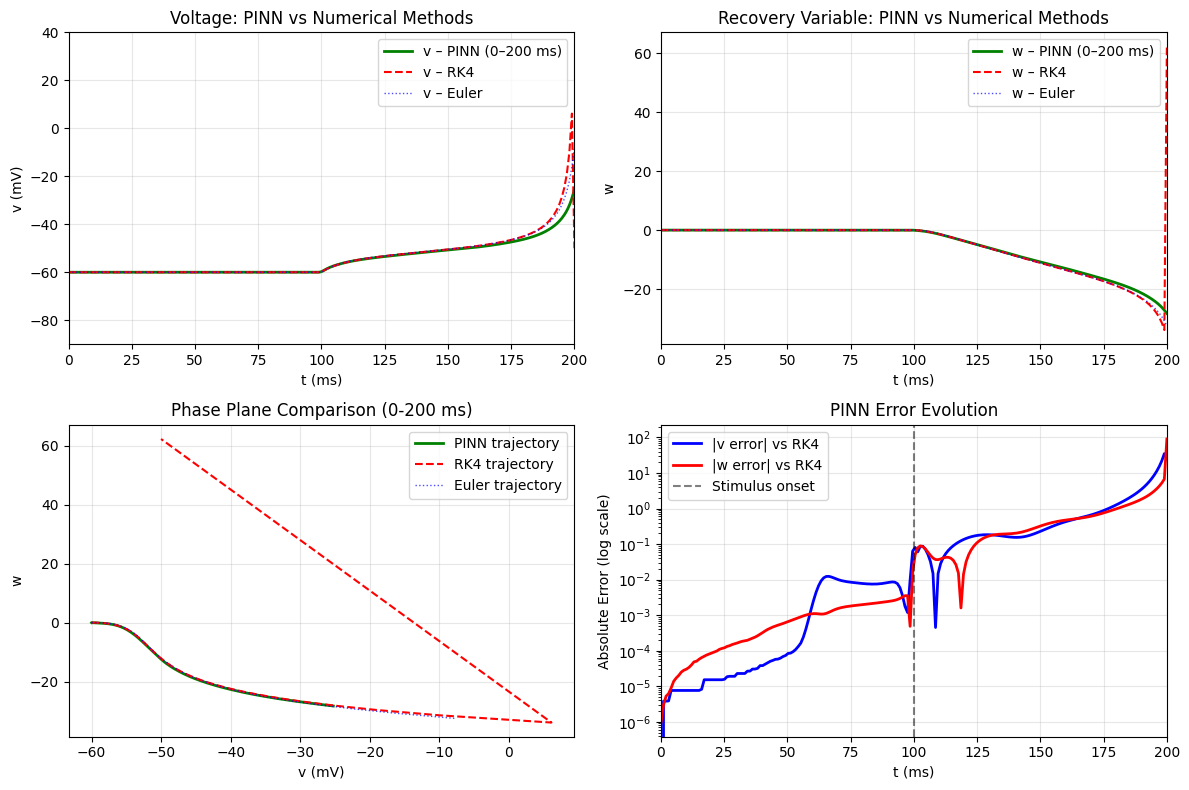


PINN TRAINING SUMMARY:
Network outputs: 2 variables (v, w)
Training window: 0-200 ms
Collocation points: 1200
Final loss: 4.664e-04

Variable ranges in training window:
  v: [-60.00, -25.24] mV
  w: [-28.28, 0.00]

Reference ranges (RK4):
  v: [-60.00, 6.12] mV
  w: [-33.90, 62.29]


In [14]:
# ------------------------------------------------------------------
# 8. COMPLETE PINN PLOTS (Both v and w variables)
# ------------------------------------------------------------------

plt.figure(figsize=(12, 8))

# Plot 1: Voltage comparison
plt.subplot(2, 2, 1)
plt.plot(t_plot, v_pred, 'g-', linewidth=2, label='v – PINN (0–200 ms)')
plt.plot(ts_rk[ts_rk<=200], v_rk[ts_rk<=200], '--r', linewidth=1.5, label='v – RK4')
plt.plot(ts_eu[ts_eu<=200], v_eu[ts_eu<=200], ':b', linewidth=1, alpha=0.7, label='v – Euler')
plt.xlim(0,200)
plt.ylim(-90,40)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.title('Voltage: PINN vs Numerical Methods')

# Plot 2: Recovery variable comparison
plt.subplot(2, 2, 2)
plt.plot(t_plot, w_pred, 'g-', linewidth=2, label='w – PINN (0–200 ms)')
plt.plot(ts_rk[ts_rk<=200], w_rk[ts_rk<=200], '--r', linewidth=1.5, label='w – RK4')
plt.plot(ts_eu[ts_eu<=200], w_eu[ts_eu<=200], ':b', linewidth=1, alpha=0.7, label='w – Euler')
plt.xlim(0,200)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlabel('t (ms)')
plt.ylabel('w')
plt.title('Recovery Variable: PINN vs Numerical Methods')

# Plot 3: Phase plane comparison
plt.subplot(2, 2, 3)
plt.plot(v_pred, w_pred, 'g-', linewidth=2, label='PINN trajectory')
plt.plot(v_rk[ts_rk<=200], w_rk[ts_rk<=200], '--r', linewidth=1.5, label='RK4 trajectory')
plt.plot(v_eu[ts_eu<=200], w_eu[ts_eu<=200], ':b', linewidth=1, alpha=0.7, label='Euler trajectory')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlabel('v (mV)')
plt.ylabel('w')
plt.title('Phase Plane Comparison (0-200 ms)')

# Plot 4: Error evolution over time
plt.subplot(2, 2, 4)
# Calculate errors at each time point for plotting
t_common = np.linspace(0, 200, 200)
v_pinn_common = pinn_v_interp(t_common)
w_pinn_common = pinn_w_interp(t_common)

# Interpolate numerical solutions to common time grid
from scipy.interpolate import interp1d
v_rk_interp = interp1d(ts_rk_200, v_rk_200, kind='linear')
w_rk_interp = interp1d(ts_rk_200, w_rk_200, kind='linear')

v_rk_common = v_rk_interp(t_common)
w_rk_common = w_rk_interp(t_common)

v_error = np.abs(v_pinn_common - v_rk_common)
w_error = np.abs(w_pinn_common - w_rk_common)

plt.plot(t_common, v_error, 'b-', linewidth=2, label='|v error| vs RK4')
plt.plot(t_common, w_error, 'r-', linewidth=2, label='|w error| vs RK4')
plt.axvline(x=100, color='k', linestyle='--', alpha=0.5, label='Stimulus onset')
plt.xlim(0, 200)
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlabel('t (ms)')
plt.ylabel('Absolute Error (log scale)')
plt.title('PINN Error Evolution')

plt.tight_layout()
plt.show()

# Summary statistics for both variables
print("\nPINN TRAINING SUMMARY:")
print("="*50)
print(f"Network outputs: {model.net[-1].out_features} variables (v, w)")
print(f"Training window: 0-200 ms")
print(f"Collocation points: {len(t_scaled)}")
print(f"Final loss: {pinn_loss(t_scaled).item():.3e}")
print()
print("Variable ranges in training window:")
print(f"  v: [{np.min(v_pred):.2f}, {np.max(v_pred):.2f}] mV")
print(f"  w: [{np.min(w_pred):.2f}, {np.max(w_pred):.2f}]")
print()
print("Reference ranges (RK4):")
print(f"  v: [{np.min(v_rk[ts_rk<=200]):.2f}, {np.max(v_rk[ts_rk<=200]):.2f}] mV")
print(f"  w: [{np.min(w_rk[ts_rk<=200]):.2f}, {np.max(w_rk[ts_rk<=200]):.2f}]")